## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from torch.utils.data import DataLoader, Dataset, Subset

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

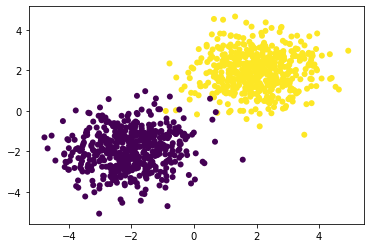

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')
plt.show()

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

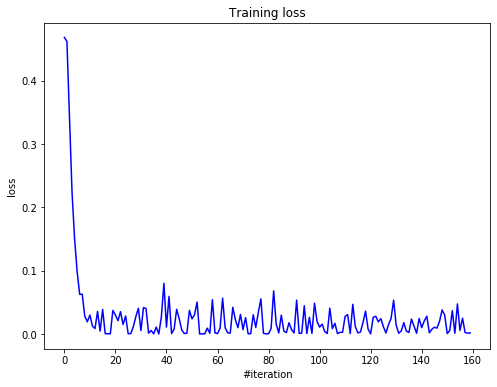

Current loss: 0.001894


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [8]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [9]:
BATCH_SIZE = 1024
N_EPOCH = 10
FEATURE_NUM = X_train.shape[1] * X_train.shape[2]
CLASSES_NUM = len(np.unique(y_train))

One-hot encode the labels first.

In [10]:
# Your code goes here. ################################################
def one_hot(labels):
    if labels.ndim != 1:
        return labels
    
    labels_one_hot = np.zeros((len(labels), len(np.unique(labels))))
    labels_one_hot[np.arange(len(labels)), labels] = 1
    return labels_one_hot

y_train, y_val, y_test = one_hot(y_train), one_hot(y_val), one_hot(y_test)

In [11]:
class DatasetMNIST(Dataset):
    def __init__(self, X, y, transform = None):
        self.X = np.array(X)
        self.y = np.array(y)
        self.transform = transform
        assert (X.shape[0] == y.shape[0])
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        obj = self.X[index]
        label = self.y[index]
        
        if self.transform is not None:
            obj = self.transform(obj)
            
        return obj, label

In [12]:
train_dataset = DatasetMNIST(X_train, y_train, transform=lambda x : x.flatten())
val_dataset = DatasetMNIST(X_val, y_val, transform=lambda x : x.flatten())
test_dataset = DatasetMNIST(X_test, y_test, transform=lambda x : x.flatten())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [13]:
# Your code goes here. ################################################
def SimpleModel(activation_layer, with_batch_norm : bool = False):
    model = Sequential()
    if with_batch_norm:
        model.add(Linear(FEATURE_NUM, CLASSES_NUM))
        model.add(BatchNormalization(0.2))
        model[1].moving_mean = np.zeros(CLASSES_NUM)
        model[1].moving_variance = np.ones(CLASSES_NUM)
        model.add(ChannelwiseScaling(CLASSES_NUM))
        model.add(activation_layer)
        model.add(LogSoftMax())
    else:
        model.add(Linear(FEATURE_NUM, CLASSES_NUM))
        model.add(activation_layer)
        model.add(LogSoftMax())
    
    return model

def train_model(train_loader, val_loader, model, optimizer, optimizer_config,
                criterion = ClassNLLCriterion(), n_epoch = N_EPOCH):
    
    iteration_train_loss = []
    ep_val_loss = []
    optimizer_state = {}
    
    for i in range(n_epoch):
        model.train()
        for X_batch, y_batch in train_loader:
            model.zeroGradParameters()

            # Forward
            predictions = model.forward(X_batch.numpy())
            loss = criterion.forward(predictions, y_batch.numpy())

            # Backward
            dp = criterion.backward(predictions, y_batch.numpy())
            model.backward(X_batch.numpy(), dp)

            # Update weights
            optimizer(
                model.getParameters(), 
                model.getGradParameters(), 
                optimizer_config,
                optimizer_state
            )      

            iteration_train_loss.append(loss)    
            
        val_loss = []
        model.evaluate()
        for X_batch, y_batch in val_loader:
            predictions = model.forward(X_batch.numpy())
            loss = criterion.forward(predictions, y_batch.numpy())
            val_loss.append(loss)
        
        ep_val_loss.append(np.mean(val_loss))
        
        print("epoch: {}\nmean train loss: {}\nmean val loss: {}\n\n".format(
                                            i,
                                            np.mean(iteration_train_loss),
                                            np.mean(ep_val_loss))
             )
        
    return iteration_train_loss, ep_val_loss

### SGD Momentum optimizer

In [14]:
sgd_momentum_config = {
    "learning_rate" : 1e-2,
    "momentum" : 0.9
}

losses_momentum = {}

In [15]:
ReLUModel = SimpleModel(ReLU())
ReLUBNModel = SimpleModel(ReLU(), with_batch_norm=True)

print("[Training ReLU]")
losses_momentum["ReLU"] = train_model(train_loader, val_loader, ReLUModel, sgd_momentum, sgd_momentum_config)
print("[Training ReLUBN]\n")
losses_momentum["ReLUBN"] = train_model(train_loader, val_loader, ReLUBNModel, sgd_momentum, {
    "learning_rate" : 1e-1,
    "momentum" : 0.9
})

[Training ReLU]
epoch: 0
mean train loss: 1.687807553110003
mean val loss: 1.06251667730039


epoch: 1
mean train loss: 1.334044202821933
mean val loss: 0.9402377403815639


epoch: 2
mean train loss: 1.170125992934756
mean val loss: 0.8726650722315396


epoch: 3
mean train loss: 1.073059084873427
mean val loss: 0.8281495109030474


epoch: 4
mean train loss: 1.0074964309882608
mean val loss: 0.7958980708994154


epoch: 5
mean train loss: 0.95959120767756
mean val loss: 0.771113706902424


epoch: 6
mean train loss: 0.9226603788678183
mean val loss: 0.7513366126862433


epoch: 7
mean train loss: 0.893149541377962
mean val loss: 0.7350816662120406


epoch: 8
mean train loss: 0.8688906488203098
mean val loss: 0.7213491338673839


epoch: 9
mean train loss: 0.848459030445154
mean val loss: 0.70959058764824


[Training ReLUBN]

epoch: 0
mean train loss: 0.9124596286814765
mean val loss: 0.3531374919827291


epoch: 1
mean train loss: 0.6378827769268637
mean val loss: 0.33251812535725844


epoch

In [16]:
ELUModel = SimpleModel(ELU())
ELUBNModel = SimpleModel(ELU(), with_batch_norm=True)

print("[Training ELU]\n")
losses_momentum["ELU"] = train_model(train_loader, val_loader, ELUModel, sgd_momentum, sgd_momentum_config)
print("[Training ELUBN]\n")
losses_momentum["ELUBN"] = train_model(train_loader, val_loader, ELUBNModel, sgd_momentum, {
    "learning_rate" : 1e-1,
    "momentum" : 0.9
})

[Training ELU]

epoch: 0
mean train loss: 1.4614770675019937
mean val loss: 0.7949640975262091


epoch: 1
mean train loss: 1.0863043548761968
mean val loss: 0.6821324718871014


epoch: 2
mean train loss: 0.9172086552872876
mean val loss: 0.6189108188529916


epoch: 3
mean train loss: 0.8178651599218337
mean val loss: 0.5768917957894025


epoch: 4
mean train loss: 0.7510342109836222
mean val loss: 0.546357602343752


epoch: 5
mean train loss: 0.7023831672337552
mean val loss: 0.5228940610355538


epoch: 6
mean train loss: 0.6649685453533271
mean val loss: 0.5040570589646471


epoch: 7
mean train loss: 0.635106606249868
mean val loss: 0.48849956981643333


epoch: 8
mean train loss: 0.6105693819946506
mean val loss: 0.47538212046845785


epoch: 9
mean train loss: 0.5899869066747024
mean val loss: 0.464107598318013


[Training ELUBN]

epoch: 0
mean train loss: 0.9251797824067375
mean val loss: 0.3579711604337904


epoch: 1
mean train loss: 0.6429957923534386
mean val loss: 0.33438533449789

In [17]:
LeakyReLUModel = SimpleModel(LeakyReLU())
LeakyReLUBNModel = SimpleModel(LeakyReLU(), with_batch_norm=True)

print("[Training LeakyReLU]\n")
losses_momentum["LeakyReLU"] = train_model(train_loader, val_loader, LeakyReLUModel, sgd_momentum, sgd_momentum_config)
print("[Training LeakyReLUBN]\n")
losses_momentum["LeakyRELUBN"] = train_model(train_loader, val_loader, LeakyReLUBNModel, sgd_momentum, {
    "learning_rate" : 1e-1,
    "momentum" : 0.9
})

[Training LeakyReLU]

epoch: 0
mean train loss: 1.703484392782059
mean val loss: 1.0883842321325685


epoch: 1
mean train loss: 1.2940845442012425
mean val loss: 0.8608390251044493


epoch: 2
mean train loss: 1.0673541742450037
mean val loss: 0.7450383733344962


epoch: 3
mean train loss: 0.9342073760707198
mean val loss: 0.674321250117991


epoch: 4
mean train loss: 0.8458866120643477
mean val loss: 0.6257071414541335


epoch: 5
mean train loss: 0.7823930494650588
mean val loss: 0.5898190068881259


epoch: 6
mean train loss: 0.734192946575587
mean val loss: 0.5619793315907656


epoch: 7
mean train loss: 0.6960973210663752
mean val loss: 0.5396095352605257


epoch: 8
mean train loss: 0.6650949953244493
mean val loss: 0.5210979033340536


epoch: 9
mean train loss: 0.6392703118802661
mean val loss: 0.5055031069377658


[Training LeakyReLUBN]

epoch: 0
mean train loss: 1.1144798856221496
mean val loss: 0.5743830970515597


epoch: 1
mean train loss: 0.7880866598680644
mean val loss: 0.4487

In [18]:
SoftPlusModel = SimpleModel(SoftPlus())
SoftPlusBNModel = SimpleModel(SoftPlus(), with_batch_norm=True)

print("[Training SoftPlus]\n")
losses_momentum["LeakyReLU"] = train_model(train_loader, val_loader, SoftPlusModel, sgd_momentum, sgd_momentum_config)
print("[Training SoftPlusBN]\n")
losses_momentum["LeakyRELUBN"] = train_model(train_loader, val_loader, SoftPlusBNModel, sgd_momentum, {
    "learning_rate" : 1e-1,
    "momentum" : 0.9
})

[Training SoftPlus]

epoch: 0
mean train loss: 1.74894439111542
mean val loss: 0.9944484249803155


epoch: 1
mean train loss: 1.2747552033381147
mean val loss: 0.8010071268392728


epoch: 2
mean train loss: 1.0521830359052817
mean val loss: 0.7038734627955229


epoch: 3
mean train loss: 0.9228986189099545
mean val loss: 0.643269605086942


epoch: 4
mean train loss: 0.8371786859249238
mean val loss: 0.6008738362446518


epoch: 5
mean train loss: 0.7754341967269694
mean val loss: 0.5691941734463275


epoch: 6
mean train loss: 0.7284831615997995
mean val loss: 0.5443404155822077


epoch: 7
mean train loss: 0.6913065504039595
mean val loss: 0.5242078898477336


epoch: 8
mean train loss: 0.6610208294304936
mean val loss: 0.5074542350759282


epoch: 9
mean train loss: 0.6357785759379111
mean val loss: 0.49328005299677596


[Training SoftPlusBN]

epoch: 0
mean train loss: 1.1595125650750149
mean val loss: 0.3803394349626184


epoch: 1
mean train loss: 0.7637888858259411
mean val loss: 0.34656

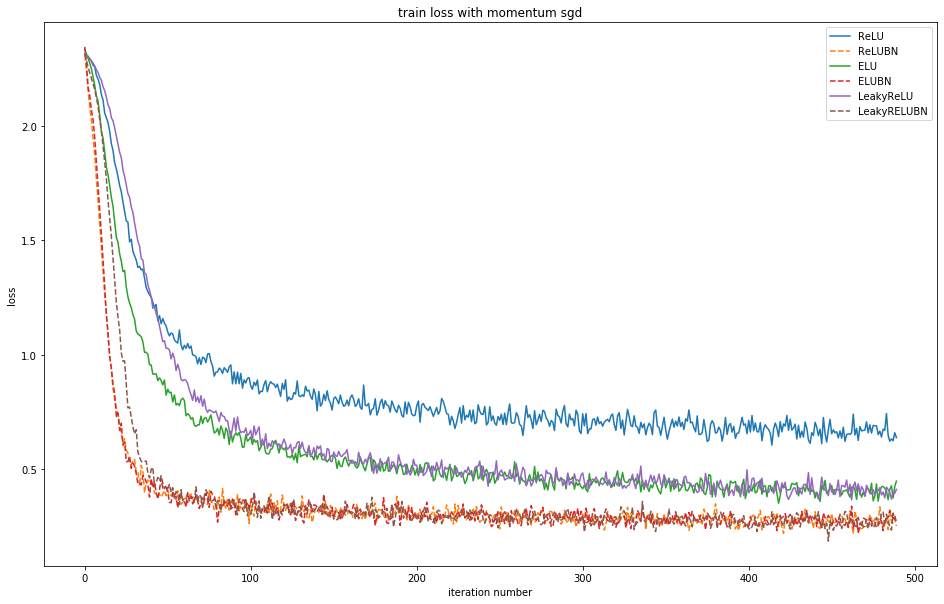

In [19]:
plt.figure(figsize=(16, 10))

for key in losses_momentum:
    if key.find("BN") != -1:
        plt.plot(losses_momentum[key][0], label=key, linestyle = '--')
    else:
        plt.plot(losses_momentum[key][0], label=key)

plt.title("train loss with momentum sgd")
plt.xlabel("iteration number")
plt.ylabel("loss")
plt.legend()
plt.show()

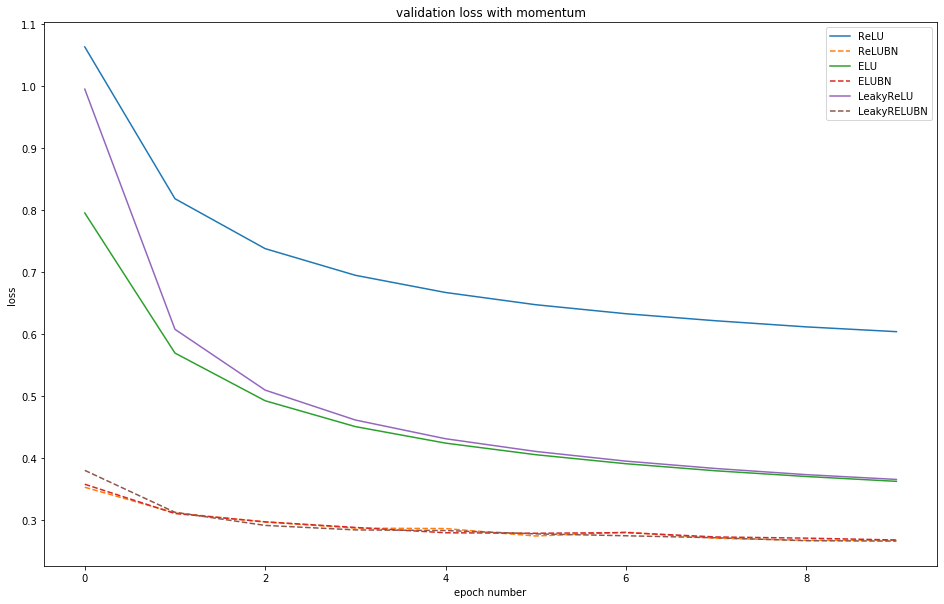

In [20]:
plt.figure(figsize=(16, 10))

for key in losses_momentum:
    if key.find("BN") != -1:
        plt.plot(losses_momentum[key][1], label=key, linestyle = '--')
    else:
        plt.plot(losses_momentum[key][1], label=key)

plt.title("validation loss with momentum")
plt.xlabel("epoch number")
plt.ylabel("loss")
plt.legend()
plt.show()

### Adam optimizer

In [21]:
adam_config_default = {
    "learning_rate" : 1e-3,
    "beta1" : 0.9,
    "beta2" : 0.999,
    "epsilon" : 1e-8
}

losses_adam = {}

In [22]:
ReLUModel = SimpleModel(ReLU())
ReLUBNModel = SimpleModel(ReLU(), with_batch_norm=True)

print("[Training ReLU]\n")
losses_adam["ReLU"] = train_model(train_loader, val_loader, ReLUModel, adam_optimizer, adam_config_default)
print("[Training ReLUBN]\n")
losses_adam["ReLUBN"] = train_model(train_loader, val_loader, ReLUBNModel, adam_optimizer, {
    "learning_rate" : 5e-2,
    "beta1" : 0.9,
    "beta2" : 0.999,
    "epsilon" : 1e-8
})

[Training ReLU]

epoch: 0
mean train loss: 1.5635376019709513
mean val loss: 0.9886247533359465


epoch: 1
mean train loss: 1.1996312509067402
mean val loss: 0.8153122421173526


epoch: 2
mean train loss: 1.0069153415058856
mean val loss: 0.7151729138801199


epoch: 3
mean train loss: 0.8866253968399921
mean val loss: 0.6484540337367724


epoch: 4
mean train loss: 0.8032657197860811
mean val loss: 0.6003486855230489


epoch: 5
mean train loss: 0.7415900893630273
mean val loss: 0.5637145449390242


epoch: 6
mean train loss: 0.6937774539221511
mean val loss: 0.5346716729475899


epoch: 7
mean train loss: 0.6554038910843287
mean val loss: 0.5109945789828556


epoch: 8
mean train loss: 0.6238125883580083
mean val loss: 0.4912759664491484


epoch: 9
mean train loss: 0.5972930085584652
mean val loss: 0.4745132779537567


[Training ReLUBN]

epoch: 0
mean train loss: 1.2554399686356874
mean val loss: 0.8441629183076383


epoch: 1
mean train loss: 1.034371594122818
mean val loss: 0.800287949443

In [23]:
ELUModel = SimpleModel(ELU())
ELUBNModel = SimpleModel(ELU(), with_batch_norm=True)

print("[Training ELU]\n")
losses_adam["ELU"] = train_model(train_loader, val_loader, ELUModel, adam_optimizer, adam_config_default)
print("[Training ELUBN]\n")
losses_adam["ELUBN"] = train_model(train_loader, val_loader, ELUBNModel, adam_optimizer, {
    "learning_rate" : 5e-2,
    "beta1" : 0.9,
    "beta2" : 0.999,
    "epsilon" : 1e-8
})

[Training ELU]

epoch: 0
mean train loss: 1.5211206119098288
mean val loss: 0.964070862954783


epoch: 1
mean train loss: 1.1717760788224554
mean val loss: 0.8017035489061906


epoch: 2
mean train loss: 0.9880990271841968
mean val loss: 0.7067268799120816


epoch: 3
mean train loss: 0.87302857090073
mean val loss: 0.6431974922779446


epoch: 4
mean train loss: 0.7929900111191084
mean val loss: 0.5969797915115818


epoch: 5
mean train loss: 0.7335757582133616
mean val loss: 0.56162981058554


epoch: 6
mean train loss: 0.6873917259896839
mean val loss: 0.5335203827841213


epoch: 7
mean train loss: 0.6502706199827165
mean val loss: 0.510519783440652


epoch: 8
mean train loss: 0.6196256781033859
mean val loss: 0.49131447259313354


epoch: 9
mean train loss: 0.593822777974806
mean val loss: 0.47496485101059294


[Training ELUBN]

epoch: 0
mean train loss: 1.0065603017713607
mean val loss: 0.43408269107282627


epoch: 1
mean train loss: 0.7035600599970802
mean val loss: 0.38190777686922894

In [24]:
LeakyReLUModel = SimpleModel(LeakyReLU())
LeakyReLUBNModel = SimpleModel(LeakyReLU(), with_batch_norm=True)

print("[Training LeakyReLU]\n")
losses_adam["LeakyReLU"] = train_model(train_loader, val_loader, LeakyReLUModel, adam_optimizer, adam_config_default)
print("[Training LeakyReLUBN]\n")
losses_adam["LeakyRELUBN"] = train_model(train_loader, val_loader, LeakyReLUBNModel, adam_optimizer, {
    "learning_rate" : 5e-2,
    "beta1" : 0.9,
    "beta2" : 0.999,
    "epsilon" : 1e-8
})

[Training LeakyReLU]

epoch: 0
mean train loss: 1.6771690236143095
mean val loss: 1.0472375713599662


epoch: 1
mean train loss: 1.266669277193242
mean val loss: 0.8477371411285453


epoch: 2
mean train loss: 1.0523645567633366
mean val loss: 0.7368708125436152


epoch: 3
mean train loss: 0.9207074166358448
mean val loss: 0.6646654447029797


epoch: 4
mean train loss: 0.8304741716656198
mean val loss: 0.6131595075246544


epoch: 5
mean train loss: 0.7641804004507617
mean val loss: 0.5742183040991252


epoch: 6
mean train loss: 0.7130459521379489
mean val loss: 0.5435868729005607


epoch: 7
mean train loss: 0.6722238972620831
mean val loss: 0.518733226306306


epoch: 8
mean train loss: 0.6387719788266867
mean val loss: 0.49806870672463316


epoch: 9
mean train loss: 0.6106996233104589
mean val loss: 0.4805611705831699


[Training LeakyReLUBN]

epoch: 0
mean train loss: 0.9894734273383444
mean val loss: 0.4161464334254374


epoch: 1
mean train loss: 0.6920419281536648
mean val loss: 0.37

In [25]:
SoftPlusModel = SimpleModel(SoftPlus())
SoftPlusBNModel = SimpleModel(SoftPlus(), with_batch_norm=True)

print("[Training SoftPlus]\n")
losses_adam["LeakyReLU"] = train_model(train_loader, val_loader, SoftPlusModel, adam_optimizer, adam_config_default)
print("[Training SoftPlusBN]\n")
losses_adam["LeakyRELUBN"] = train_model(train_loader, val_loader, SoftPlusBNModel, adam_optimizer, {
    "learning_rate" : 5e-2,
    "beta1" : 0.9,
    "beta2" : 0.999,
    "epsilon" : 1e-8
})

[Training SoftPlus]

epoch: 0
mean train loss: 1.6730712023652725
mean val loss: 1.0247588150175009


epoch: 1
mean train loss: 1.2531054124866432
mean val loss: 0.8236520039091452


epoch: 2
mean train loss: 1.0362419907269196
mean val loss: 0.7141133107201715


epoch: 3
mean train loss: 0.9042521773883762
mean val loss: 0.6436187274718717


epoch: 4
mean train loss: 0.8143797863572086
mean val loss: 0.5939024464662788


epoch: 5
mean train loss: 0.748742970379966
mean val loss: 0.5564622146478791


epoch: 6
mean train loss: 0.6983123726380172
mean val loss: 0.527155313061272


epoch: 7
mean train loss: 0.6581829597853641
mean val loss: 0.5034099413555453


epoch: 8
mean train loss: 0.6253499880627849
mean val loss: 0.4837222541131282


epoch: 9
mean train loss: 0.5979108190716479
mean val loss: 0.4671547147542463


[Training SoftPlusBN]

epoch: 0
mean train loss: 1.0226007239846446
mean val loss: 0.3991267189719463


epoch: 1
mean train loss: 0.7020398855122323
mean val loss: 0.36062

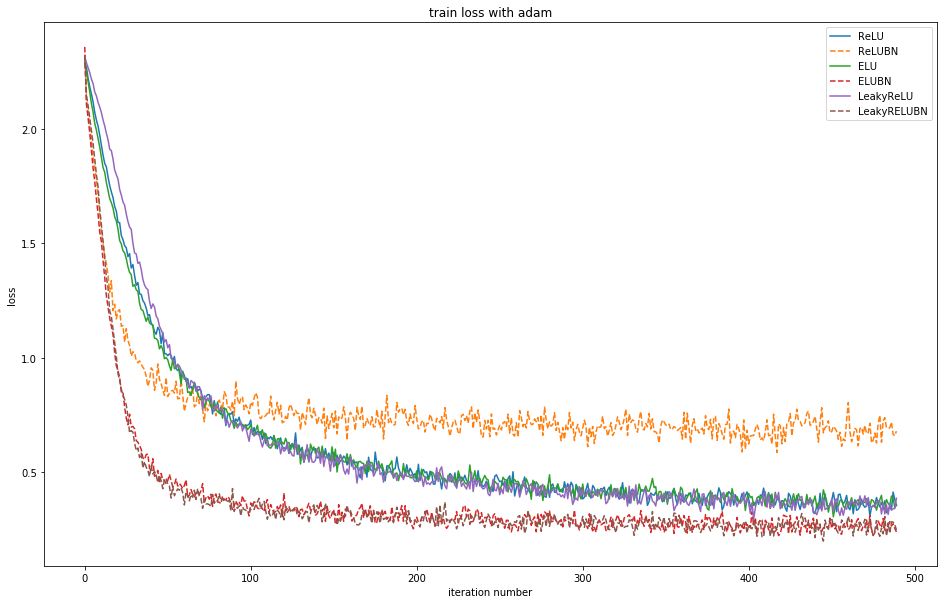

In [26]:
plt.figure(figsize=(16, 10))

for key in losses_adam:
    if key.find("BN") != -1:
        plt.plot(losses_adam[key][0], label=key, linestyle = '--')
    else:
        plt.plot(losses_adam[key][0], label=key)

plt.title("train loss with adam")
plt.xlabel("iteration number")
plt.ylabel("loss")
plt.legend()
plt.show()

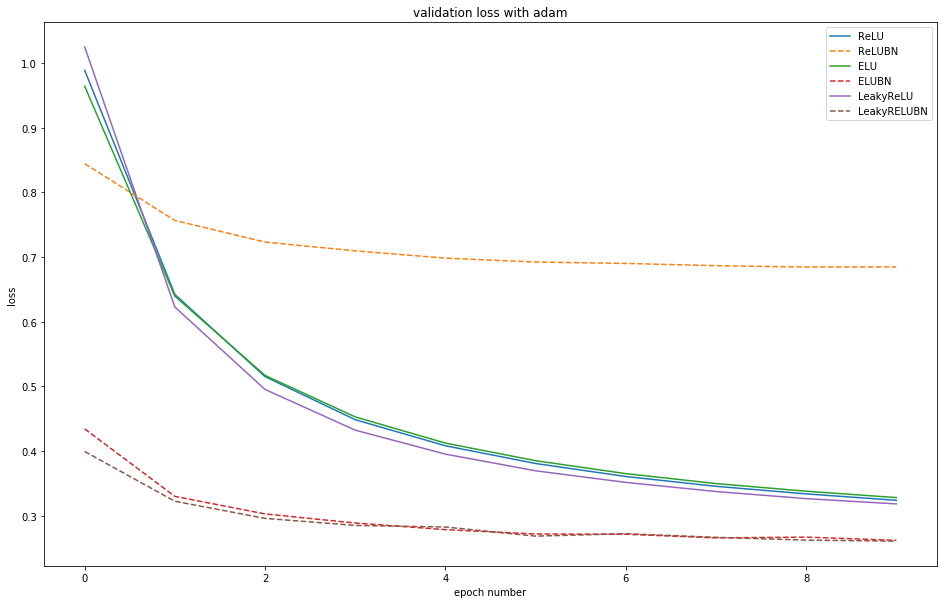

In [27]:
plt.figure(figsize=(16, 10))

for key in losses_adam:
    if key.find("BN") != -1:
        plt.plot(losses_adam[key][1], label=key, linestyle = '--')
    else:
        plt.plot(losses_adam[key][1], label=key)

plt.title("validation loss with adam")
plt.xlabel("epoch number")
plt.ylabel("loss")
plt.legend()
plt.show()

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

- Лучше всего в обоих случая показала себя ELU, хуже остальных - ReLU. Однако ELU содержит exp, которую затратно вычислять, поэтому я склоняюсь к выбору LeakyReLU, которая лишена проблемы ReLU с нулевым градиентом, а также вычислительно не затратна

- Добавление батчнорма позволяет обучаться лучше увеличивая learning_rate, тк нормируя выход с линейного слоя мы получаем гарантию того, что данные в следующий слой скорее всего придут с mean = 0, variance = 1 и мы можем изменять веса на бо'льшую величину, по сравнению с моделью без батчнорма. Также наличие shift + scale позволяет тюнить эти параметры, адаптируясь под следующий слой.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [28]:
# Your code goes here. ################################################

Print here your accuracy on test set. It should be around 90%.

In [29]:
# Your answer goes here. ################################################

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [30]:
# Your beautiful code here.